In [8]:
import sys
import scipy.io as sio
import h5py
import numpy as np
from os.path import join as oj
import matplotlib.pyplot as plt
# %matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
import pandas as pd
# from mpl_toolkits.mplot3d import Axes3D
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path

from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn import decomposition
import matplotlib.gridspec as grd
from sklearn import neural_network

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
data_dir = '/scratch/users/vision/data/neuro_misc/stringer_data_b'
os.listdir(data_dir)

['natimg2800_small_M170717_MP034_2017-09-17.mat',
 'images_natimg2800_8D_M170717_MP033_2017-08-22.mat',
 'natimg2800_M170717_MP033_2017-08-20.mat',
 'images_natimg2800_8D_M170604_MP031_2017-07-02.mat',
 'images_natimg2800_white_all.mat',
 'natimg2800_8D_M170717_MP034_2017-09-15.mat',
 'natimg2800_8D_M161025_MP030_2017-06-07.mat',
 'images_natimg2800_small_M170717_MP033_2017-08-23.mat',
 'ori32_M160825_MP027_2016-12-15.mat',
 'natimg2800_white_M170717_MP034_2017-09-14.mat',
 'natimg2800_white_M170717_MP033_2017-09-21.mat',
 'images_natimg2800_8D_M170714_MP032_2017-08-10.mat',
 'images_natimg2800_all.mat',
 'natimg2800_4D_M170717_MP034_2017-09-20.mat',
 'natimg2800_M170717_MP034_2017-09-11.mat',
 'natimg2800_8D_M170714_MP032_2017-09-15.mat',
 'natimg32_M170717_MP033_2017-08-25.mat',
 'images_natimg2800_4D_M170717_MP034_2017-09-20.mat',
 'dbstims.mat',
 'natimg32_M150824_MP019_2016-03-23.mat',
 'images_natimg2800_8D_M170714_MP032_2017-09-15.mat',
 'natimg2800_M170604_MP031_2017-06-28.mat'

In [36]:
mt = sio.loadmat(oj(data_dir, 'natimg2800_M160825_MP027_2016-12-14.mat'))

### stimulus responses
resp = mt['stim'][0]['resp'][0]    # stimuli by neurons
istim = mt['stim'][0]['istim'][0]   # identities of stimuli in resp
spont = mt['stim'][0]['spont'][0]  # timepoints by neurons

### cell information
med = mt['med']                 # cell centers (X Y Z)
mt['stat'][0]     # first cell’s stats
mt['stat'][0]['npix']       # one example field, tells you how pixels make up the cell

### loading images
mt_ims = sio.loadmat(oj(data_dir, 'images_natimg2800_all.mat'))
imgs = mt_ims['imgs']  # 68 by 270 by number of images

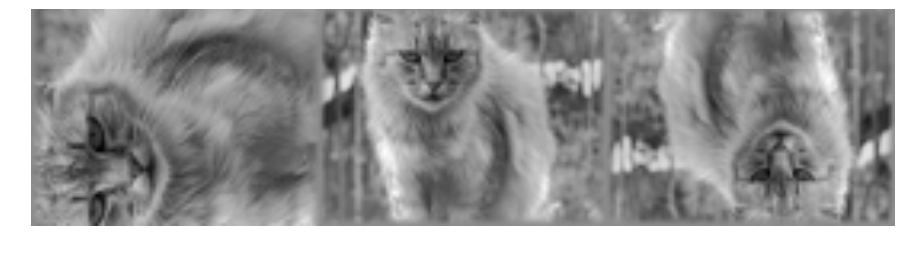

In [49]:
# check out an image using matplotlib.pyplot
plt.figure(figsize=(16, 4))
plt.imshow(imgs[:, :, -1], cmap='gray', interpolation='bilinear')
plt.axis('off')
plt.show()

In [59]:
print(resp.shape, istim.shape, np.min(istim), np.max(istim), imgs.shape, spont.shape)

(5426, 11449) (5426, 1) 1 2801 (68, 270, 2800) (4696, 11449)


In [69]:
istim[istim <= 2000].flatten().shape

(3671,)

In [55]:
(istim <= 2000) * (istim >= 2000)

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [104]:
from stringer_dset import StringerDset
dset = StringerDset()

In [113]:
dset.istim.dtype

dtype('<u2')

In [106]:
(x, y) = dset[1]
print(x.shape)

(68, 90)


uint8
float32


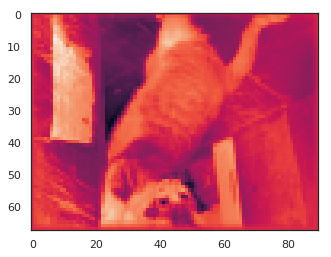

In [112]:
print(x.dtype)
plt.imshow(x) #.astype(np.float32))
print(y.dtype)

# view some responses

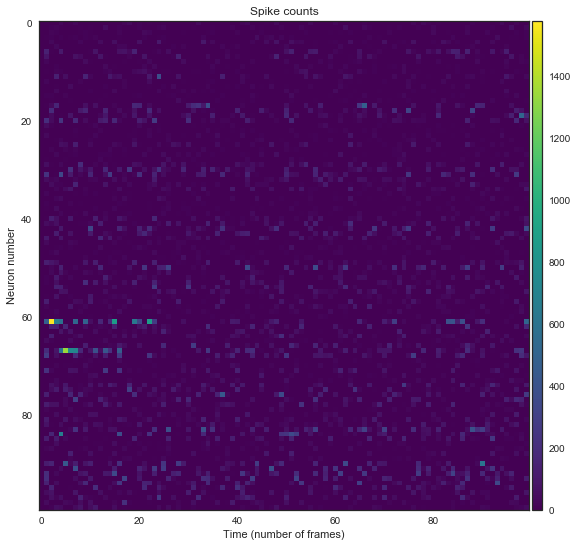

In [18]:
plt.figure(figsize=(16, 9))
ax = plt.gca()
p = plt.imshow(X[:100, :100], interpolation='None', cmap='viridis')
plt.xlabel('Time (number of frames)')
plt.ylabel('Neuron number')
plt.title('Spike counts')

# colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(p, cax=cax)

plt.show()

# look at PCs

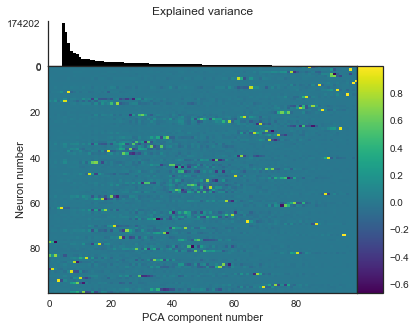

In [10]:
def plot_pcs(pca, comps):

    # create a 2 X 2 grid 
    gs = grd.GridSpec(2, 2, height_ratios=[2,10], 
                      width_ratios=[12, 1], wspace=0, hspace=0)

    try:
        # plot explained variance
        ax2 = plt.subplot(gs[0])
        ax2.bar(np.arange(0, comps.shape[1]), pca.explained_variance_, 
                color='black', width=1)
        plt.title('Explained variance')
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.xaxis.set_visible(False)
        ax2.yaxis.set_ticks_position('left')
        ax2.set_yticks([0, max(pca.explained_variance_)])
    except:
        print('not pca')

    # plot pcs
    ax = plt.subplot(gs[2])
    p = ax.imshow(comps, interpolation='None', cmap='viridis',aspect='auto')
    plt.ylabel('Neuron number')
    plt.xlabel('PCA component number')

    # make colorbar
    colorAx = plt.subplot(gs[3])
    cb = plt.colorbar(p, cax = colorAx)

    plt.show()


# perform pca
pca = decomposition.PCA()
# pca = decomposition.NMF()
pca.fit(X[:100].transpose())
comps = pca.components_.transpose()
plt.figure(figsize=(6, 5))
plot_pcs(pca, comps)

In [89]:
fname=oj('/scratch/users/vision/data/neuro_misc/stringer_data_b', 'natimg2800_M160825_MP027_2016-12-14.mat')
train=True
crop_center=True
trans=None
mt = sio.loadmat(oj(data_dir, 'natimg2800_M160825_MP027_2016-12-14.mat'))

### stimulus responses
istim = mt['stim'][0]['istim'][0]   # (n x num_neurons) identities of stimuli in resp        
resp = mt['stim'][0]['resp'][0]    # (n x num_neurons) stimuli by neurons

if train:
    idxs = (istim <= 2000)
else:
    idxs = (istim > 2000) * (istim < 2801) # 2801 signals gray screen
idxs = idxs.flatten()
self.istim = istim[idxs]
self.resp = resp[idxs]



NameError: name 'self' is not defined

In [91]:
### loading images
mt_ims = sio.loadmat(oj(data_dir, 'images_natimg2800_all.mat'))
if crop_center:        
    imgs = mt_ims['imgs'][:, 90:180, :]  # 68 by 90 by number of images
else:
    imgs = mt_ims['imgs']  # 68 by 270 by number of images


NameError: name 'self' is not defined

In [92]:
imgs2 = imgs.transpose((2, 0, 1))

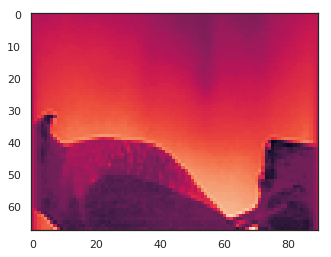

In [94]:
plt.imshow(imgs2[1])